## Monte Carlo simulation of stable membrane curvatures

##### Using functions from mem_curve.py

In [1]:
# Standard imports
import matplotlib.pyplot as plt
import pandas as pd
import os
# For reading csv
import csv
import re
# For power spectrum
from scipy.signal import periodogram

# Custom imports
from mem_curve import *

### Running simulation, replica exchange, annealing

#### Simulation:
Initialise model membrane, run Monte Carlo for <n> steps

#### Replica exchange:
Access surfaces otherwise separated by potential barriers...
Tune kbT factor up & down to alter acceptance ratio from equilibrium ensemble
Run parallel simulation windows, can swap replicas between kbT environments

#### Annealing:
Slowly return kbT factor to equilibrium
If too quick, will form "glass" -- initially all moves "downhill" & become trapped in metastable state space

In [2]:
# Choose number of Monte Carlo steps
nsteps = 50000

# Choose directory to save/ load
save_dir = 'trial5'
os.makedirs(f'./{save_dir}/', exist_ok=True)

# Initialise membrane ensemble
membrane_lst = [init_model_membrane()]

In [ ]:
# OPTIONAL !
# Make distortion to initial membrane
membrane_lst[0]['alpha'] += 1
membrane_lst[0]['beta']  -= 1
membrane_lst[0]['gamma'] -= 1
membrane_lst[0]['zeta']  += 1

# Calculate first membrane energy
# Calculate shape operator
S = calc_shape_operator(membrane_lst[0], params.X, params.Y)
# Calculate mean and Gaussian curvatures
H   = calc_H(S)
K_G = calc_K_G(S)
# Calculate bending energy
bending_energy = calc_Helfrich_energy(H, K_G)

# Add energy to dictionary attributes
membrane_lst[0]['energy'] = bending_energy

print(bending_energy)

In [3]:
# Track acceptance probability
naccepts      = 0
accepts_track = []

# Run simulation
for step in range(1,nsteps+1):
    
    membrane_lst, accept_move = montecarlostep(membrane_lst)

    naccepts += 1 if accept_move else 0
    accepts_track += [naccepts]
    
    if step%2000==0 and step!=0:
        print(f'Step {step}: accepted moves {naccepts}')

print('Acceptance ratio:', naccepts/nsteps)

Step 2000: accepted moves 1623
Step 4000: accepted moves 3254
Step 6000: accepted moves 4847
Step 8000: accepted moves 6448
Step 10000: accepted moves 8071
Step 12000: accepted moves 9690
Step 14000: accepted moves 11293
Step 16000: accepted moves 12896
Step 18000: accepted moves 14518
Step 20000: accepted moves 16130
Step 22000: accepted moves 17751
Step 24000: accepted moves 19355
Step 26000: accepted moves 21015
Step 28000: accepted moves 22627
Step 30000: accepted moves 24219
Step 32000: accepted moves 25830
Step 34000: accepted moves 27462
Step 36000: accepted moves 29059
Step 38000: accepted moves 30674
Step 40000: accepted moves 32309
Step 42000: accepted moves 33925
Step 44000: accepted moves 35560
Step 46000: accepted moves 37162
Step 48000: accepted moves 38763
Step 50000: accepted moves 40367
Acceptance ratio: 0.80734


In [4]:
# Save data to a csv
df = pd.DataFrame(membrane_lst)

df.to_csv(f'./{save_dir}/model_membranes.csv', index=False)

### load data from saved csv

In [3]:
def string_to_array(s):
    s_clean = re.sub(r'[\[\]]', '', s)
    if ' ' not in s_clean:
        return float(s_clean)
    return np.array([[float(x) for x in line.split() if x]
                     for line in s_clean.strip().split('\n')])

with open(f'./{save_dir}/model_membranes.csv', mode='r', newline='') as file:
    reader = csv.DictReader(file)
    membrane_lst = []
    for row in reader:
        parsed_row = {}
        for key, val in row.items():
            parsed_row[key] = string_to_array(val)
        membrane_lst.append(parsed_row)

### Data Analysis

#### Equilibration

How does ratio of accepted moves evolve?

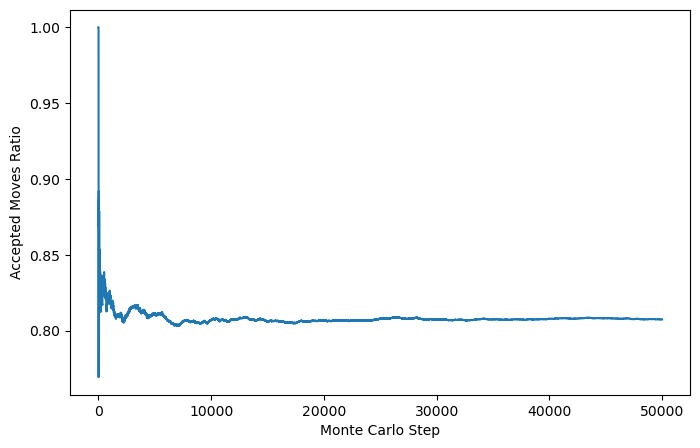

In [5]:
# note: won't work if data has been loaded
mcsteps_arr = np.linspace(1,nsteps,nsteps)
ratio_arr = np.array(accepts_track)/mcsteps_arr

plt.figure(figsize=[8,5])
plt.ylabel('Accepted Moves Ratio')
plt.xlabel('Monte Carlo Step')
plt.plot(mcsteps_arr, ratio_arr)
plt.savefig(f'./{save_dir}/naccepts.pdf')
plt.show()

#### Plot bending energy vs Monte Carlo step
#### Plot mean curvature vs Monte Carlo step
#### Plot Gaussian curvature vs Monte Carlo step
^ are these values expected? Are states stable &/ in equilibrium ensemble?

In [6]:
# Extract bending energy from membrane_lst of dictionaries
energy_lst = [ membrane['energy'] for membrane in membrane_lst ]

# Calculate values every <nframes>
nframes = 10

H_lst = []
K_lst = []

for membrane in membrane_lst[::nframes]:

    # Calculate shape operator
    S = calc_shape_operator(membrane, params.X, params.Y)
    # Calculate mean and Gaussian curvatures
    H_lst += [np.sum(calc_H(S))]
    K_lst += [np.sum(calc_K_G(S))] 

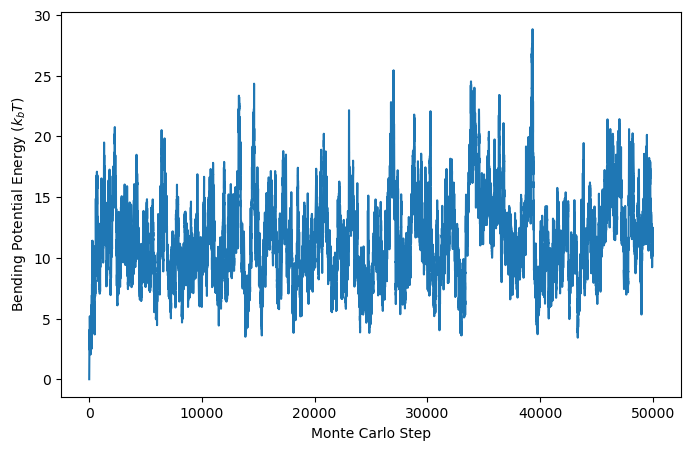

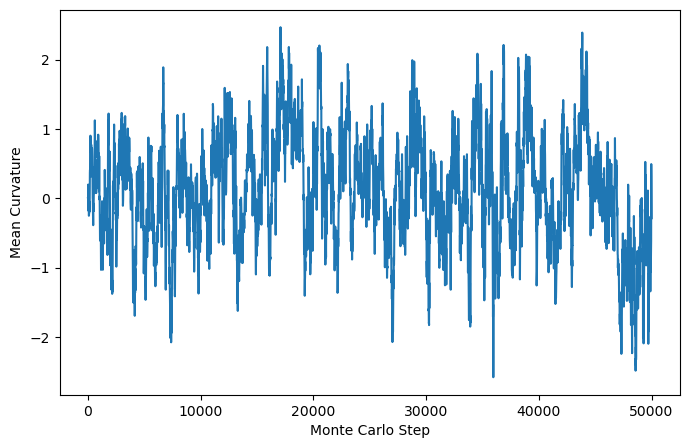

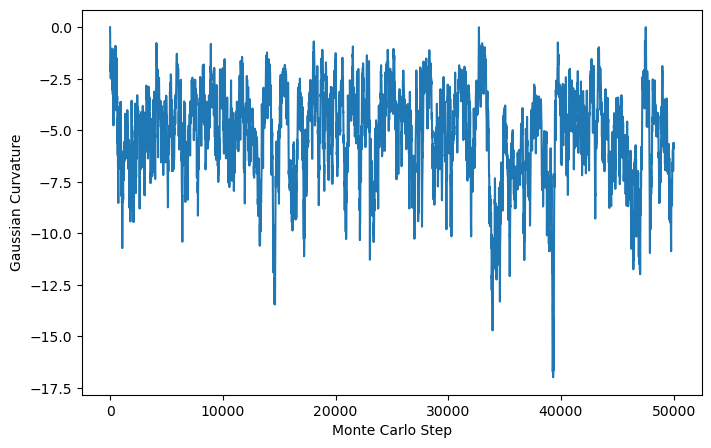

In [7]:
# Plot energy
plt.figure(figsize=[8,5])
plt.ylabel('Bending Potential Energy ($k_bT$)')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1), energy_lst)
plt.savefig(f'./{save_dir}/bending_energy.pdf')
plt.show()

# Plot mean curvature
plt.figure(figsize=[8,5])
plt.ylabel('Mean Curvature')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), H_lst)
plt.savefig(f'./{save_dir}/mean_curvature.pdf')
plt.show()

# Plot Gaussian curvature
plt.figure(figsize=[8,5])
plt.ylabel('Gaussian Curvature')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), K_lst)
plt.savefig(f'./{save_dir}/Gaussian_curvature.pdf')
plt.show()

#### Take mean of height 
From equilibrium sampled region

Is average membrane structure flat?

#### Take mean squared height
How does membrane thickness compare to CWT..?

$\langle h(\textbf{r})^{2} \rangle = \frac{k_bT}{16\pi^{3} \kappa} L^{2} $

In [8]:
# Skip steps before equilibrium
nskip = 10000

# Calculate values every <nframes>
nframes = 10

# Simulated values
mean_height   = 0 
meansq_height = 0 

for membrane in membrane_lst[nskip::nframes]:

    # Calculate height
    mem_height     = calc_height(membrane, params.X, params.Y)
    mean_height   += np.mean(mem_height) # average over all grids
    meansq_height += np.max(mem_height)**2 /2 + np.min(mem_height)**2 /2
    
mean_height   /= len(membrane_lst[nskip::nframes])
meansq_height /= len(membrane_lst[nskip::nframes])

# Theoretical value (from Capillary Wave Theory on membranes)
cwt_meansq_h = params.kbT / (16 * np.pi**3 * params.kappa_H) * params.l_x * params.l_y

In [9]:
print(f'''
<h> = {mean_height} (simulated)
<h> = 0.0 (CWT)

<h^2> = {meansq_height} (simulated) 
<h^2> = {cwt_meansq_h} (CWT)''')


<h> = 1.312615144310237 (simulated)
<h> = 0.0 (CWT)

<h^2> = 3.3303565846317893 (simulated) 
<h^2> = 0.25196511275937106 (CWT)


#### Save logging info

In [11]:
log_str = f'''
# # # Parameters # # #

Box parameters:
l_x       = {params.l_x}    # Box size, x-direction
l_y       = {params.l_y}    # Box size, y-direction
exp_order = {params.exp_order}     # Order of 2D Fourier expansion
npts      = {params.npts}    # Number of points in each unit l_x, l_y for grid calculations

Bending energies:
H_0     = {params.H_0}     # Optimum mean curvature
kappa_H = {params.kappa_H}     # Bending modulus of mean curvature (kbT units)
kappa_K = {params.kappa_K}     # Bending modulus of Gaussian curvature (kbT units)

Size of Monte Carlo moves:
delta = {params.delta}     # Standard deviation of perturbation applied to Fourier coefficients

Number of steps:
nsteps = {nsteps}


# # # Results # # #

Acceptance ratio   = {naccepts/nsteps}

Curvature:
Bending energy     = {np.mean(energy_lst[int(nskip/nframes):])}
Mean curvature     = {np.mean(H_lst[int(nskip/nframes):])}
Guassian curvature = {np.mean(K_lst[int(nskip/nframes):])}

Membrane height:
mean height = {mean_height} (simulated)
mean height = 0.0                   (CWT)
mean squared height = {meansq_height} (simulated)
mean squared height = {cwt_meansq_h} (CWT)

Note: averages after {nskip} steps
'''

filename = f"./{save_dir}/log.txt"

# Write the string to the file
with open(filename, "w") as file:
    file.write(log_str)

print(f'Log file saved as {filename}')

Log file saved as ./trial5/log.txt


#### Histogram of curvatures

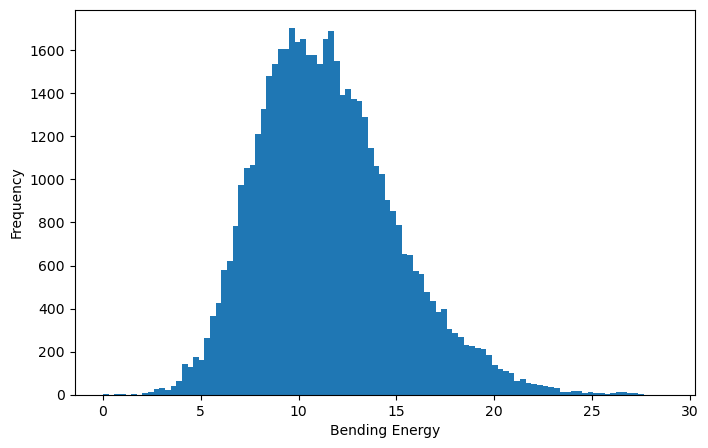

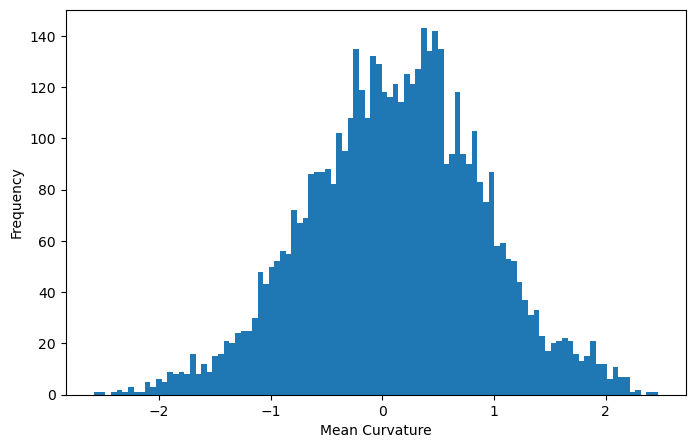

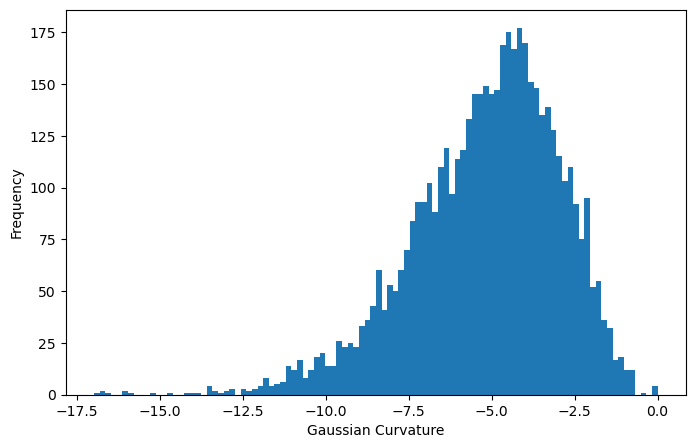

In [12]:
plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Bending Energy')
plt.hist(energy_lst, bins=100)
plt.savefig(f'./{save_dir}/Gaussian_curvature_bin.pdf')
plt.show()

plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Mean Curvature')
plt.hist(H_lst, bins=100)
plt.savefig(f'./{save_dir}/Gaussian_curvature_bin.pdf')
plt.show()

plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Gaussian Curvature')
plt.hist(K_lst, bins=100)
plt.savefig(f'./{save_dir}/Gaussian_curvature_bin.pdf')
plt.show()

#### Mean Fourier Coefficients

$
h(x, y) =
\sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \alpha_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \beta_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \gamma_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \delta_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
$


In [13]:
nskip = 10000

# Calculate mean Fourier coefficients
alpha_lst, beta_lst, gamma_lst, zeta_lst = [], [], [], []

for membrane in membrane_lst[:nskip]:
    alpha_lst += [membrane['alpha']]
    beta_lst  += [membrane['beta']]
    gamma_lst += [membrane['gamma']]
    zeta_lst  += [membrane['zeta']]

alpha_mean = np.mean(alpha_lst, axis=0)
beta_mean  = np.mean(beta_lst, axis=0)
gamma_mean = np.mean(gamma_lst, axis=0)
zeta_mean  = np.mean(zeta_lst, axis=0)

Fcoeff_means = [alpha_mean, beta_mean, gamma_mean, zeta_mean]

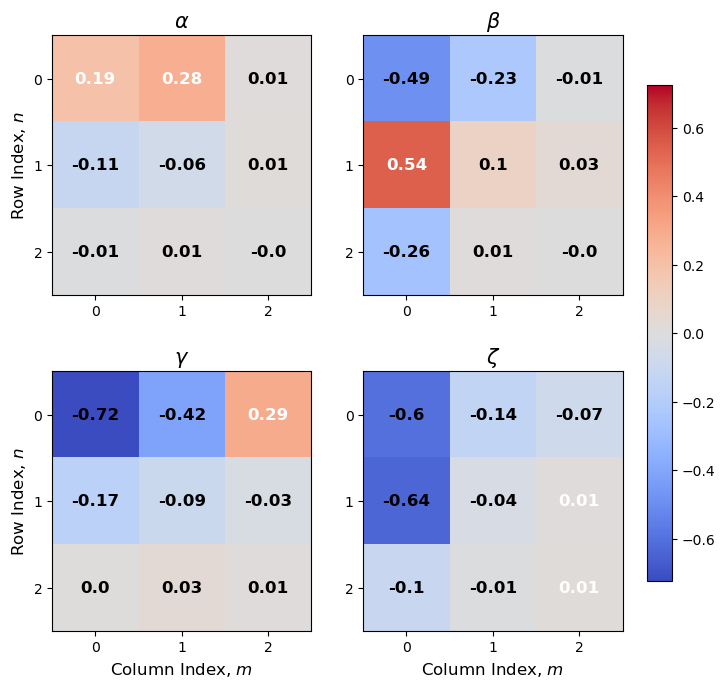

In [14]:
# Plot mean Fourier coeff values
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

titles = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\zeta$']

# find maximum absolute value for colourbar reference
maxval = np.max(Fcoeff_means) if np.max(Fcoeff_means)>abs(np.min(Fcoeff_means)) else abs(np.min(Fcoeff_means))

for idx, (ax, cm) in enumerate(zip(axes, Fcoeff_means)):
    im = ax.imshow(cm, cmap='coolwarm', vmin=-maxval, vmax=maxval)
    ax.set_title(titles[idx], fontsize=15)
ed in 1880
    # Annotate each cell
    for i in range(params.exp_order):
        for j in range(params.exp_order):
            ax.text(j, i, f'{round(Fcoeff_means[idx][i,j],2)}',
                    ha='center', va='center',
                    color='white' if cm[i, j] > cm.max() / 2 else 'black',
                    fontsize=12, fontweight='bold')

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    if idx in [2,3]:
        ax.set_xlabel(r'Column Index, $m$', fontsize=12)
    if idx in [0,2]:
        ax.set_ylabel(r'Row Index, $n$', fontsize=12)

# Add a shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.04, pad=0.04)
#cbar.set_label('Mean Fourier Coefficient Value', fontsize=13)

#plt.tight_layout(pad=2)
plt.savefig(f'./{save_dir}/Fcoeff.pdf')
plt.show()

#### Power Spectrum

In [15]:
# Calculate power spectrum
f, Pxx = periodogram(energy_lst)

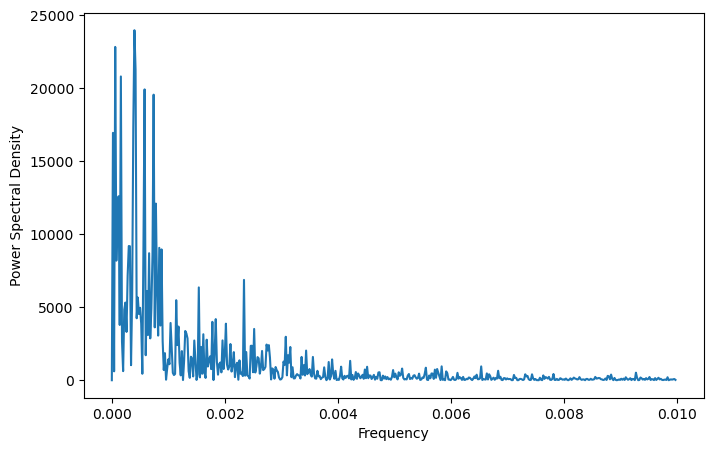

In [16]:
upto = 500
plt.figure(figsize=[8,5])
plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency')
plt.plot(f[:upto], Pxx[:upto])
plt.savefig(f'./{save_dir}/pwr_spectral_dens.pdf')
plt.show()

#### Visualising membrane curvature

In [17]:
# Set plots as pop-ups
%matplotlib qt

In [18]:
# Visualise membrane curvatures with contour plot movie
visualise(membrane_lst, nframes=200, save_dir=save_dir)

In [19]:
# Set plots to in line
%matplotlib inline

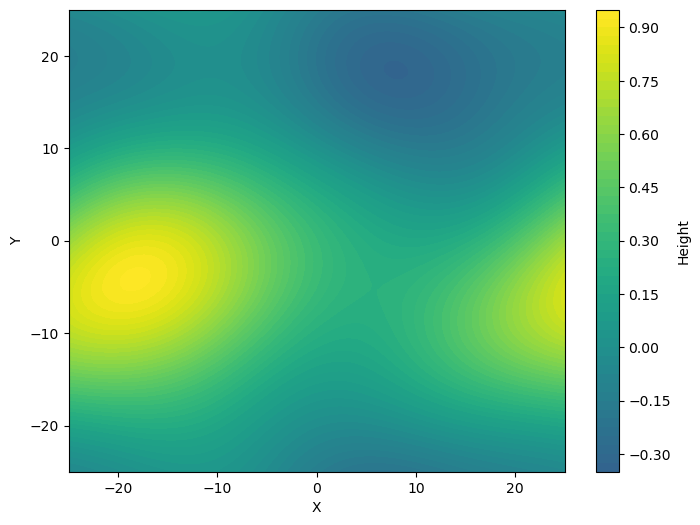

In [24]:
# Visualise 'mean surface'
# X,Y grid
npts = 100
x = np.linspace(-params.l_x/2, params.l_x/2, npts)
y = np.linspace(-params.l_y/2, params.l_y/2, npts)
X, Y = np.meshgrid(x, y)

# Calculate z-direction (heights)
mean_membrane = {
    'alpha' : alpha_mean,
    'beta'  : beta_mean,
    'gamma' : gamma_mean,
    'zeta'  : zeta_mean} 

Z = calc_height(mean_membrane, X, Y)

# Animation plot
fig, ax = plt.subplots(figsize=[8, 6])

# Initial contour and colorbar
maxval = np.max(Z) if np.max(Z)>abs(np.min(Z)) else abs(ed in 1880np.min(Z))
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis', vmin=-maxval, vmax=maxval)
cbar = fig.colorbar(contour, ax=ax)

# Labels
cbar.set_label("Height")
#title = ax.set_title("Mean Membrane Height")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.savefig(f'./{save_dir}/mean_surface.pdf')
plt.show()

### Test finite size & boundary artifacts

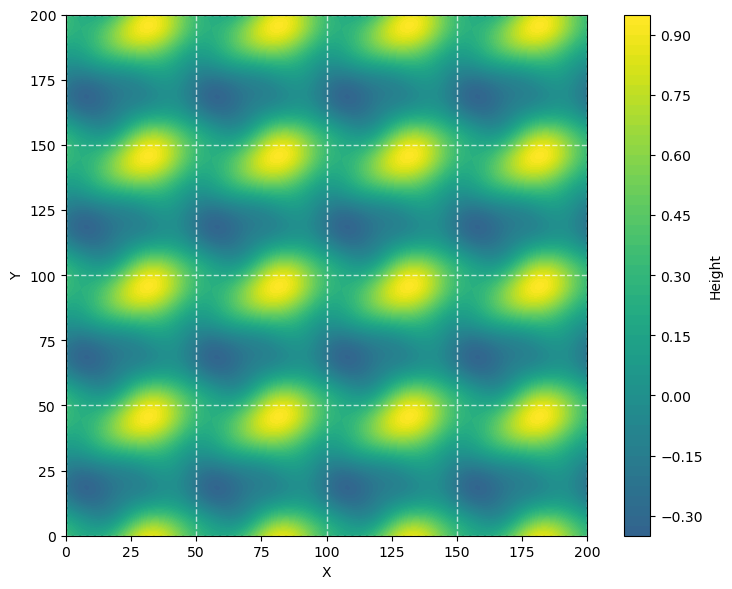

In [65]:
# Visualise 'mean surface' over multiple box lengths
nboxes = 4

# X, Y grid
npts = 100
x = np.linspace(0, params.l_x * nboxes, npts * nboxes)
y = np.linspace(0, params.l_y * nboxes, npts * nboxes)
X, Y = np.meshgrid(x, y)

# Calculate z-direction (heights)
mean_membrane = {
    'alpha': alpha_mean,
    'beta': beta_mean,
    'gamma': gamma_mean,
    'zeta': zeta_mean
}
Z = calc_height(mean_membrane, X, Y)

# Figure setup
fig, ax = plt.subplots(figsize=[8, 6])

# Contour plot
maxval = np.max(Z) if np.max(Z) > abs(np.min(Z)) else abs(np.min(Z))
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis', vmin=-maxval, vmax=maxval)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Height")

# Axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")

# grid lines at multiples of box length
for i in range(nboxes+1):  # 0 to 4 boxes
    ax.axvline(x=i * params.l_x, color='white', lw=1.0, ls='--', alpha=0.7)
    ax.axhline(y=i * params.l_y, color='white', lw=1.0, ls='--', alpha=0.7)

# make sure the grid lines appear on top
ax.set_axisbelow(False)

# clean styling
ax.set_xlim(0, params.l_x * 4)
ax.set_ylim(0, params.l_y * 4)
ax.set_aspect('equal')  # Square cells if physical lengths match

plt.tight_layout()
plt.show()

#### Periodic box boundary position!

Grid over which energy is calculated vs for simulation results in changes in energy

Artifact!

How does this vary with (simulated) box size?

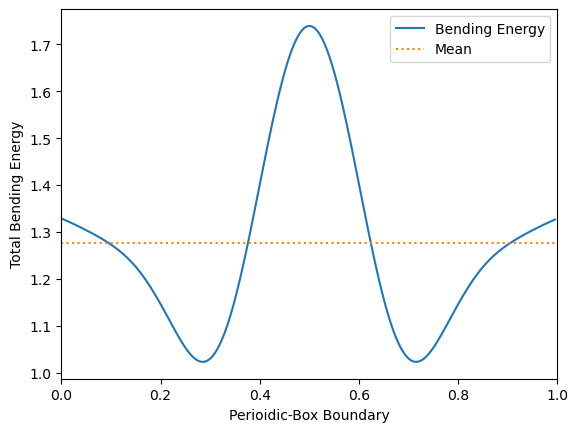

In [109]:
U_lst = []
t = 200

l_x = l_y = 50
# note: if differs from simulation box size, will have superposition of boundary effects

for n in range(0,t):

    m = t - n

    # X, Y grid for calculations
    npts = 4     
    x = np.linspace(n*l_x/t, m*l_x/t, l_x * npts)
    y = np.linspace(n*l_y/t, m*l_y/t, l_y * npts)
    X, Y = np.meshgrid(x, y)
    
    # Calculate shape operator
    S = calc_shape_operator(mean_membrane, X, Y)
    # Calculate mean and Gaussian curvatures
    H   = calc_H(S)
    K_G = calc_K_G(S)
    # Calculate bending energy
    # from 'calc_helfrich_energy'
    energy_per_l = 2*params.kappa_H * ( H - params.H_0 )**2 + abs(params.kappa_K * K_G) # abs to avoid negative bending energy??
    subgrid_area = 1 / (npts**2) # for integration over total area: l_x * l_y / ( l_x*npts * l_y*npts )
    bending_energy = np.sum(energy_per_l) * subgrid_area
    
    U_lst += [bending_energy]

plt.figure()
plt.ylabel('Total Bending Energy')
plt.xlabel('Perioidic-Box Boundary')
plt.plot(np.arange(t)/t, U_lst, label='Bending Energy')
plt.plot( [0,1], [np.mean(U_lst)]*2 , linestyle=':', label='Mean')
plt.xlim(0,1)
plt.legend(loc='best')
plt.show()

#### Periodic Box Size

No issues! - Linear relationship between square root of total bending energy to box side length

Note: 'dimple' due to periodic boundary effect

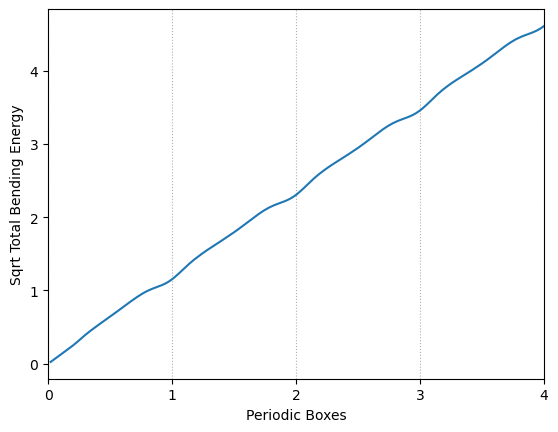

The gradient of sqrt total energy w/ respect to box l is 4.609858382014752


In [100]:
U_lst = []
t_max = 200
t_range = np.arange(1, t_max+1)
for n in t_range:
    # X, Y grid for calculations
    l_x = 1 * n
    l_y = 1 * n
    
    npts = 2
    x = np.linspace(0, l_x, l_x * npts)
    y = np.linspace(0, l_y, l_y * npts)
    X, Y = np.meshgrid(x, y)
    
    # Calculate shape operator
    S = calc_shape_operator(mean_membrane, X, Y)
    # Calculate mean and Gaussian curvatures
    H   = calc_H(S)
    K_G = calc_K_G(S)
    # Calculate bending energy
    # from 'calc_helfrich_energy'
    energy_per_l = 2*params.kappa_H * ( H - params.H_0 )**2 + abs(params.kappa_K * K_G) # abs to avoid negative bending energy??
    subgrid_area = 1 / (npts**2) # for integration over total area: l_x * l_y / ( l_x*npts * l_y*npts )
    bending_energy = np.sum(energy_per_l) * subgrid_area
    
    U_lst += [bending_energy]

grad_U_vs_l = np.sqrt(U_lst[-1])-np.sqrt(U_lst[0])/(t_range[-1]-t_range[0])
print('The gradient of sqrt total energy w/ respect to box l is', grad_U_vs_l)

plt.figure()
plt.ylabel('Sqrt Total Bending Energy')
plt.xlabel('Periodic Boxes')
plt.plot(t_range, np.sqrt(U_lst))
plt.grid(linestyle=':', axis='x')
plt.xticks(np.arange(0, t_max+1, 50),[str(n) for n in range(len(range(0, t_max+1, 50)))])
plt.xlim(0, t_max)
plt.show()

#### Grid division -- number of integration points per unit length
No issues!

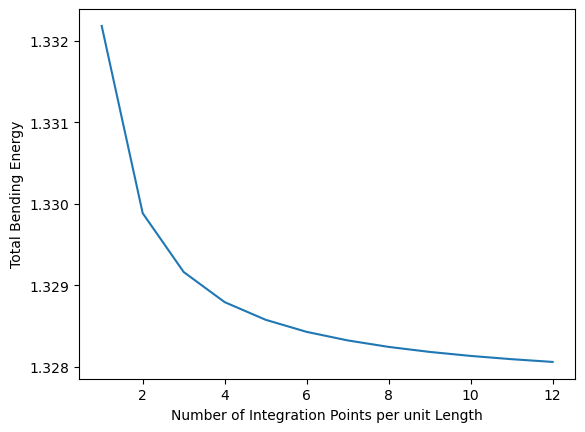

In [110]:
U_lst = []
npts_range = range(1, 12+1)

l_x = l_y = 50
# note: if differs from simulation box size, will have superposition of boundary effects

for npts in npts_range:

    # X, Y grid for calculations   
    x = np.linspace(0, l_x, l_x * npts)
    y = np.linspace(0, l_y, l_y * npts)
    X, Y = np.meshgrid(x, y)
    
    # Calculate shape operator
    S = calc_shape_operator(mean_membrane, X, Y)
    # Calculate mean and Gaussian curvatures
    H   = calc_H(S)
    K_G = calc_K_G(S)
    # Calculate bending energy
    # from 'calc_helfrich_energy'
    energy_per_l = 2*params.kappa_H * ( H - params.H_0 )**2 + abs(params.kappa_K * K_G) # abs to avoid negative bending energy??
    subgrid_area = 1 / (npts**2) # for integration over total area: l_x * l_y / ( l_x*npts * l_y*npts )
    bending_energy = np.sum(energy_per_l) * subgrid_area
    
    U_lst += [bending_energy]

plt.figure()
plt.ylabel('Total Bending Energy')
plt.xlabel('Number of Integration Points per unit Length')
plt.plot(npts_range, U_lst)
plt.show()